# OBJECTIVE : Exploratory Data Analysis, Classification

# DATASET
### Source : default of credit card clients Data Set ( https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients )
### Attribute Information:
````
This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable.  
This study reviewed the literature and used the following 23 variables as explanatory variables:  

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
X2: Gender (1 = male; 2 = female).
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
X4: Marital status (1 = married; 2 = single; 3 = others).
X5: Age (year).
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows:a
    X6 = the repayment status in September, 2005;
    X7 = the repayment status in August, 2005;
    . . .;
    X11 = the repayment status in April, 2005.
    The measurement scale for the repayment status is:
        -1 = pay duly;
        1 = payment delay for one month;
        2 = payment delay for two months;
        . . .;
        8 = payment delay for eight months;
        9 = payment delay for nine months and above.
X12-X17: Amount of bill statement (NT dollar).
    X12 = amount of bill statement in September, 2005;
    X13 = amount of bill statement in August, 2005;
    . . .;
    X17 = amount of bill statement in April, 2005.
X18-X23: Amount of previous payment (NT dollar).
    X18 = amount paid in September, 2005;
    X19 = amount paid in August, 2005;
    . . .;
    X23 = amount paid in April, 2005.
````    

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

### Get in the data

In [24]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('# Samples in train:', train.shape[0])
print('# Samples in test:', test.shape[0])

train.drop(columns=['Unnamed: 0', 'ID'], inplace=True)
train.rename(columns={'default payment next month': 'labels'}, inplace=True)


train.head()

# Samples in train: 24169
# Samples in test: 5831


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,labels
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
2,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
3,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
4,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0


## Analysing the Labels
Lets see the ratio of defaulters vs non-defaulters in the dataset.  
```
Label Mapping:  
0 : Non-Defaulters  
1 : Defaulters
```



Percentage of Class 1 [Defaulters] : 0.21842029045471473
Percentage of Class 0 [Non-Defaulters] : 0.7815797095452853

Defaulter Ratio for the Dataset:
{ ( # of samples w/ label = 1 ) / ( # samples w/ labels = 0 )} : 0.27946003176283746


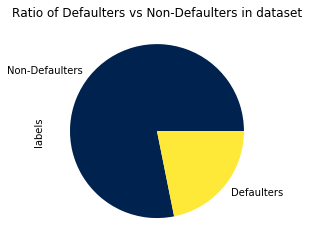

In [25]:
train.labels.value_counts().plot(kind='pie', labels=['Non-Defaulters', 'Defaulters'], colormap='cividis', title='Ratio of Defaulters vs Non-Defaulters in dataset')

perc_1 = train.labels.value_counts()[1] / train.labels.count()
perc_0 = train.labels.value_counts()[0] / train.labels.count()

print('\nPercentage of Class 1 [Defaulters] :', perc_1)
print('Percentage of Class 0 [Non-Defaulters] :', perc_0)
print()
DEFAULT_DEFAULTER_RATIO = perc_1 / perc_0
print('Defaulter Ratio for the Dataset:\n{ ( # of samples w/ label = 1 ) / ( # samples w/ labels = 0 )} :', DEFAULT_DEFAULTER_RATIO)

### Some convenience functions

In [26]:

def see_current_scores(df, imps=False, graph=False):
    '''
    This is a convenience function that we use to see changes in the Feature Importance Scores from
    Random Fores Classifier (w/ Default RFC Parameters) with changing the features (s.a. adding / removing features from the dataset)
    and monitor the dip / rise in Accuracy / F1.
    '''
    
    #train-val split
    x_train, x_val , y_train, y_val = train_test_split(df.iloc[:,:-1], df.iloc[:,-1],
                                                     test_size=0.15, random_state=43)
    # using RFC for benchmark
    rfc = RandomForestClassifier(n_estimators=20)
    rfc.fit(x_train, y_train)
    predictions = rfc.predict(x_val)
    print('Score from RFC:', rfc.score(x_val, y_val))
    print("F1 score from RFC:", f1_score(y_val, predictions))
    
    if (imps):
        feature_imps = {}
        print("\nFeature Importances:")
        ix = np.argsort(rfc.feature_importances_)[::-1]
        for i,j in zip(rfc.feature_importances_[ix],x_train.columns[ix]):
            print(i,j)
            feature_imps[j] = i
    
    if(graph):
        x = list(feature_imps.keys())
        y = list(feature_imps.values())
        plt.barh(x,y,log=True)
        plt.title('Feature Importance of features in Logarithm Scale')
        plt.show()
        
        

def defaulter_ratio_cat_feature(df, col):
    '''
    ===> Use only with categorical features <===
    creates a map of unique values in features w.r.t. defaulter ratio.
    defaulter_ratio = (# of defaulters) / (# of non-defaulters)
    
    eg, pay val =-2 means prepayment by 2 months
        and has lower default rates in general,
        so -2 maps to a lower defaulter ratio (in most cases)
    '''
    map = {}
    a = df[col].unique()
    for i in a:
        try:
            bad_guys = df.labels[df[col] == i].value_counts()[1.0]
        except KeyError:
            bad_guys = 0
        try:
            good_guys = df.labels[df[col] == i].value_counts()[0]
        except KeyError:
            good_guys = 0
        try:
            ratio = float(bad_guys) / float(good_guys)
        except ZeroDivisionError:
            ratio = 0
        map[i] = ratio
    return map


### We get the RFC Feature Importance for the training data without any changes to the dataset.
### This will help us benchmark any changes that we may do later

Score from RFC: 0.8149476006618864
F1 score from RFC: 0.4704025256511444

Feature Importances:
0.10070174392969314 PAY_0
0.06527782126151625 AGE
0.06183971373302292 BILL_AMT1
0.05696205798453922 LIMIT_BAL
0.05530673955911354 BILL_AMT2
0.0539047681263472 PAY_AMT1
0.05194003882193895 BILL_AMT3
0.05054405811445124 BILL_AMT4
0.04938675599501732 BILL_AMT5
0.049175375137253646 BILL_AMT6
0.04835494763935806 PAY_AMT2
0.04634228833200701 PAY_AMT3
0.044685808456402784 PAY_AMT6
0.04325642497984431 PAY_AMT4
0.043200250624010894 PAY_AMT5
0.034181918389702574 PAY_2
0.032054171956657156 PAY_4
0.029993267354382642 PAY_3
0.02170132909460064 EDUCATION
0.02131755039250523 PAY_6
0.014218867986069078 MARRIAGE
0.01397631600728087 PAY_5
0.011677786124285262 SEX


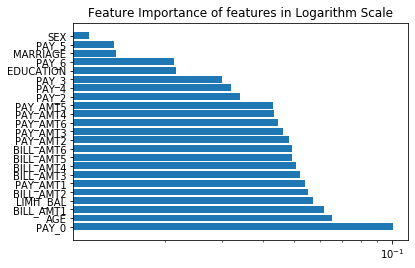

In [27]:
see_current_scores(train, imps=True, graph=True)

## Analysis of PAY_x attributes:
```
As per the dataset:
-1 = pay duly;
1 = payment delay for one month;
2 = payment delay for two months;
. . .;
8 = payment delay for eight months;
9 = payment delay for nine months and above.
```



### We try to visualize the ratio of people who have defaulted payment w.r.t the number of months their payment was delayed.
#### Obviously, as expected, people who have delayed payments for more that 1 month, have a much higher probability of defaulting the next payment


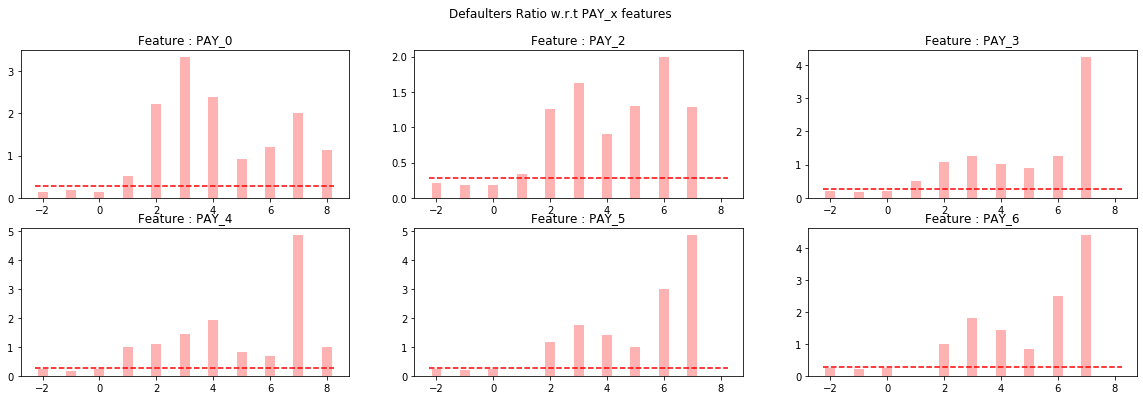

In [28]:
# Defaulters Ratio w.r.t PAY_x features


attrib = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
fig = plt.figure(figsize=(20,6))
fig.suptitle('Defaulters Ratio w.r.t PAY_x features')

i=1
for ax in attrib:
    fig.add_subplot(2, 3, i)
    mapping = defaulter_ratio_cat_feature(train, ax)
    ind = mapping.keys()
    D_ratio = []
    for ix in ind:
        D_ratio.append(mapping[ix])
    p1 = plt.bar(ind, D_ratio, width=0.35,color='red', alpha=0.3)
    plt.plot([min(ind)-0.25, max(ind)+0.25], [DEFAULT_DEFAULTER_RATIO, DEFAULT_DEFAULTER_RATIO], "r--")
    plt.title('Feature : {}'.format(ax))
    i -=- 1


```
Note: The red horizontal line inbelow graphs mark the ratio of [ Defaulters / Non-Defaulters ].  
If  values for a categorical feature is much higher or much smaller lower the horizonrtal line, it turns out to be a very useful feature for classification.
Similarly, if any feature, s.a. SEX or MARRIAGE, (as we will see in below graphs) that are very close to the red horizontal line turns out to be not much useful features for classification.

We can say this coz if you compare the graphs with the feature importance scores from RFC, its all coherent
```

## Exploring features: SEX, MARRIAGE, AGE & EDUCATION   
### We saw above that these features have the least importances in predicting the labels from rfc.featuer_importances_  
#### Lets do some plotting to see their defaulters ratio.
#### The horizontal line in these plots mark the Default Ratio for Defaulters vs Non-defaulters for the dataset

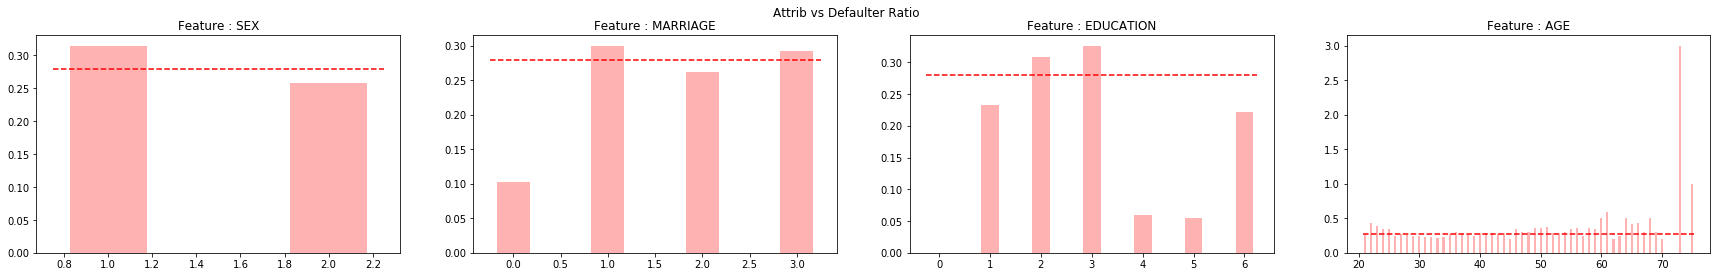

In [29]:
attribs = ['SEX', 'MARRIAGE', 'EDUCATION', 'AGE']


fig, axs = plt.subplots(1,4)
fig.suptitle('Attrib vs Defaulter Ratio')

fig.set_figheight(4)
fig.set_figwidth(30)

for i,ax in enumerate(attribs):
    mapping = defaulter_ratio_cat_feature(train, ax)
#     print(mapping)
    ind = mapping.keys()
    D_ratio = []
    for ix in ind:
        D_ratio.append(mapping[ix])
    p1 = axs[i].bar(ind, D_ratio, width=0.35,color='red', alpha=0.3)
    axs[i].plot([min(ind)-0.25, max(ind)+0.25], [DEFAULT_DEFAULTER_RATIO, DEFAULT_DEFAULTER_RATIO], "r--")
    axs[i].set_title('Feature : {}'.format(ax))


```

Seems Men are more likely to default payment, as they have a little higher defaulting ratio.  
But still SEX as a feature score very little in the RFC feature importance.  
  

**_Overall defaulter ratio of the dataset ( 21.84 / 78.15 ~ 0.27 )  {i.e. # samples with class labels 1 / # samples with class labels 0}_**  
  
**One important thing worth noticing would be that if the defaulter ratio for any value in any feature is very close to the overall defaulter ratio of the dataset ( 21.84 / 78.15 ~ 0.27 ), then it probably is not going to be a very useful thing for us.  
The farther the defaulter ratio is from 0.27, the better.**  
  

The information we observe here is very coherent with the feature importance from RFC we observed above.  
SEX and MARRIAGE have their defaulter ratios very close around 0.27
EDUCATION has its ratios much farther than 0.27.


What we will try next is removeing these features altogether, and see the performance dip/rise.
```

In [30]:
train_low_features_removed = train.drop(columns=['SEX', 'MARRIAGE'])
print("Scores with all features")
see_current_scores(train)
print()
print("Scores After Removing Features")
see_current_scores(train_low_features_removed)


print("Dropping SEX & MARRIAGE from dataset.")
train.drop(columns=['SEX', 'MARRIAGE'], inplace=True)
test.drop(columns=['SEX', 'MARRIAGE'], inplace=True)

Scores with all features
Score from RFC: 0.8099834528405957
F1 score from RFC: 0.44835868694955966

Scores After Removing Features
Score from RFC: 0.815223386651958
F1 score from RFC: 0.4657097288676237
Dropping SEX & MARRIAGE from dataset.


```
A very slight dip/rise in F1 score after removing SEX & MARRIAGE, as compared to the previous result with no change in dataset.  
But we cannot be too sure of that.  
We remove the features for now.
```

### Lets Create New features

The features BILL_AMTx are the amount the credit card holder is billed each month from April to September.
And PAY_AMTx are the payments the person makes from April to September.

One thing we can infer from the data is the relation between BILL_AMTx and PAY_AMTx.


In [31]:
#print(train.columns)

sample = train.iloc[[18,26,58,61],:][['PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]

bills = sample.values[:,6:12]
payments = sample.values[:,12:18]
delta = bills[:,1:] - payments[:,:-1]
print('Delta values for chosen samples for 5 months:\n',delta)
sample

Delta values for chosen samples for 5 months:
 [[   0    0    0    0    0]
 [  -5  -15    0    0 -369]
 [   0    0    0    0    0]
 [-163 -116  -23 -399 -129]]


,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
18,-1,-1,-1,-1,-1,-1,316,316,316,0,632,316,316,316,0,632,316,0
26,-1,-1,-1,-1,-1,-1,16646,17265,13266,15339,14307,36923,17270,13281,15339,14307,37292,0
58,-1,-1,-1,-1,-1,-1,780,0,390,390,390,390,0,390,390,390,390,390
61,-1,-1,-1,-1,-1,-1,3048,5550,23337,4291,80153,25820,5713,23453,4314,80552,25949,2016


```  
We have deliberately chosen sample #18, #26, #58, #61 to understand this, since they have -1 {paid duly} for all 6 months.  
So BILL_AMT6 is bill generated for April & PAY_AMT5 is the payment made in May for April's bill.  
So delta that these good people maintain every month ( sample #18, #26, #58, #61) is almost 0 every month.  
And a negative delta value means they are making pre-payments.
  
Using this observation, we can have the delta that each person maintains for a maximum of 5 months.  
(Since PAY_AMT6 is payment made in April, for March's bill, whose data we do not have.)  
(BILL_AMT1 is bill generated in September, but we do not have payment amount for this bill.)  
  
We will add a new column in the data which is the mean of the delta for the 5 months and see its feature importance. 
```

In [32]:
def add_delta_feature(df):
    bills = df[['BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].values
    payments = df[['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].values
    limit = df[['LIMIT_BAL']].values
    delta  = bills[:,1:] - payments[:,:-1]
    delta = delta.mean(axis=1)

    df_with_delta =  df.copy()
    df_with_delta.insert(loc=5, column='delta_mean', value=delta)
    return df_with_delta

train = add_delta_feature(train)
test = add_delta_feature(test)
#Apply same operations to test data too


In [33]:
print("Scores with new additional delta Feature:")
see_current_scores(train, imps=True)

Scores with new additional delta Feature:
Score from RFC: 0.8116381687810259
F1 score from RFC: 0.4549082202713488

Feature Importances:
0.0941086461474113 PAY_0
0.06657239391158107 AGE
0.0596879800386184 LIMIT_BAL
0.05766891471350403 BILL_AMT1
0.05480351583936569 PAY_2
0.051729280355022125 BILL_AMT2
0.04947380220952916 BILL_AMT6
0.049361694656283095 PAY_AMT1
0.04920373680382543 BILL_AMT3
0.04900910300546527 delta_mean
0.047966974632952186 BILL_AMT4
0.047632632439123294 BILL_AMT5
0.046671388322658866 PAY_AMT2
0.04559178293879919 PAY_AMT6
0.04457914863292707 PAY_AMT5
0.04425658803990508 PAY_AMT3
0.0415021768133546 PAY_AMT4
0.021350353762193238 PAY_3
0.020333454506104468 PAY_5
0.019603796102161977 PAY_6
0.019471129442837427 PAY_4
0.01942150668637711 EDUCATION


```
So, our new feature **delta_mean** has captured some meaningful information from PAY_AMTx and BILL_AMTx.  
It is **9th most important feature among 25 features**.  
{ THIS RANK MAY VARY A LITTLE WITH EACH RUN}
```

## Done with the features, move to **Model**
### MODEL 1 **RFC**
Lets do some tuning with RandomForestClassifier
Some local hyperparameter search on RandomForestClassifier usinf sklearn's GridCVSearch returned the following parameters for RFC when scored on accuracy.
 - max_depth : 7
 - criterion : 'gini'
 - n_estimators : 75

In [34]:
x_train, x_val , y_train, y_val = train_test_split(train.iloc[:,:-1], train.iloc[:,-1],
                                                     test_size=0.15, random_state=43)

In [35]:
rfc = RandomForestClassifier(max_depth=7, criterion='gini', n_estimators=75)

rfc.fit(x_train, y_train)
predictions = rfc.predict(x_val)
predict_proba = rfc.predict_proba(x_val)
print('Score from RFC:', rfc.score(x_val, y_val))
print("F1 score from RFC with probability threshold 0.5:", f1_score(y_val, predictions))


Score from RFC: 0.819911748483177
F1 score from RFC with probability threshold 0.5: 0.46953696181965876


### Tune the threshold for making predictions  
#### Instead of making a class label prediction with probability threshold = 0.5.  
#### We shift the threshold and see the effect on F1 score & Accuracy.

F1 score with threshold = 0.2 	 :  0.5489383738995338
F1 score with threshold = 0.21 	 :  0.5475935828877005
F1 score with threshold = 0.22 	 :  0.5522552255225524
F1 score with threshold = 0.23 	 :  0.5572476029328821
F1 score with threshold = 0.24 	 :  0.562536023054755
F1 score with threshold = 0.25 	 :  0.5603296056503826
F1 score with threshold = 0.26 	 :  0.5557543231961837
F1 score with threshold = 0.27 	 :  0.5547445255474454
F1 score with threshold = 0.28 	 :  0.5551425030978934
F1 score with threshold = 0.29 	 :  0.5531112507856694
F1 score with threshold = 0.3 	 :  0.5487884741322855
F1 score with threshold = 0.35 	 :  0.5346260387811634
F1 score with threshold = 0.4 	 :  0.5139911634756995
F1 score with threshold = 0.45 	 :  0.48631743549648165
F1 score with threshold = 0.5 	 :  0.46953696181965876
F1 score with threshold = 0.55 	 :  0.4378194207836457
F1 score with threshold = 0.6 	 :  0.35992578849721707
F1 score with threshold = 0.65 	 :  0.28428428428428426


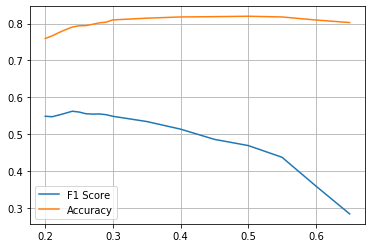



Maximum F1 score obtained with threshold 0.24 is 0.562536023054755


In [36]:
def hypertune_threshold(pred_prob, y_val, graph=False):
    '''
    Another convenience function.
    It uses the predicted probabilities form a Classification Model,
    and searches through a range of values for probability threshold for making a prediction.
    eg. If model predicts a probability P_P and prediction probability threshold is P_T,
    Then we predict a 1 when P_P > P_T
        we predict a 0 when P_P < P_T.
    This kind of tuning is especially useful when we are handling imbalanced dataset, with a non 50-50 distribution of class labels.
    '''
    f1_scores = {}
    accuracy = {}
    T = [0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65]
    for t in T:
        predictions=[]
        for i in pred_prob:
            if(i[1] > t):
                predictions.append(1)
            else:
                predictions.append(0)
        predictions = np.array(predictions)
        accuracy[t] = 1 - (predictions - y_val).abs().sum() / predictions.shape[0]
        print("F1 score with threshold =",t,"\t : ", f1_score(y_val, predictions))
        f1_scores[t] = f1_score(y_val, predictions)
    
    y1 = list(f1_scores.values())
    y2 = list(accuracy.values())
    max_T = T[np.argmax(y1)]
    if (graph):
        
        plt.plot(T, y1, label='F1 Score')
        plt.plot(T,y2, label='Accuracy')
        plt.legend()
        plt.grid()
        plt.show()
    
    max_F1 = f1_scores[max_T]
    return max_T, max_F1

max_T, max_F1 = hypertune_threshold(predict_proba, y_val, graph=True)
print("\n\nMaximum F1 score obtained with threshold {} is {}".format(max_T, max_F1))